In [2]:
''' 
    @author: BALAVIGNESH M

    DATE: 27/07/2020

    Code Scope:
      To Predict the Stock Market and Forecasting for 30 days by using Stacked LSTM
'''


# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
%matplotlib inline 

dataFrame = pd.read_csv('apple_stock.csv')
dataFrame.head(5)

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [3]:
# We need to predict the pricing so now taking the closing amount for our purpose

new_Dataframe = dataFrame.reset_index()['close']
new_Dataframe.head()

0    132.045
1    131.780
2    130.280
3    130.535
4    129.960
Name: close, dtype: float64

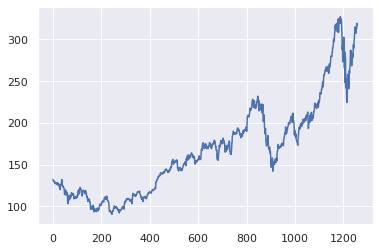

In [4]:
plt.plot(new_Dataframe)

In [5]:
# LSTM is sensitive to scale data so we need to apply the MinMax Sclar for preprocess the data

from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler(feature_range=(0,1)) # Here feature_range means convert the data point to range between 0 to 1
newdataframe = minmaxscaler.fit_transform(np.array(new_Dataframe).reshape(-1,1)) # Here reshape is should be used for LSTM
# news = pd.DataFrame(newdataframe)
# news.head()
print(newdataframe)

[[0.17607447]
 [0.17495567]
 [0.16862282]
 ...
 [0.96635143]
 [0.9563033 ]
 [0.96491598]]


In [6]:
# Splitting the train and test set
train_size = int(len(newdataframe) * 0.75)
test_size = int(len(newdataframe) - train_size)
traindata,testdata = newdataframe[0:train_size,],newdataframe[train_size:len(newdataframe)]

In [7]:
# convert the data array to data set matrix with time step 

''' 
  If Time step is '4' then X contains for '0' iteration ======> 0,1,2,3 and Y will be 4

  Example For following Function

  '0' iteration:
  ------------------
    X =================> 0:0+4 => 0:4 => 0,1,2,3
    Y =================> 0+4   => 4   => 4
'''

def MakedataSet(dataset=None, timestep=None):
  dataX,dataY= [],[]
  for i in range(len(dataset)-timestep-1):
    dataX.append(dataset[i:(i+timestep), 0]) 
    dataY.append(dataset[i + timestep, 0]) 
  return np.array(dataX), np.array(dataY)

In [8]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
timestep= 75
X_train, Y_train = MakedataSet(traindata, timestep)
x_test, y_test = MakedataSet(testdata, timestep)

In [9]:
print(X_train.shape), print(Y_train.shape)

(867, 75)
(867,)


(None, None)

In [10]:
print(x_test.shape), print(y_test.shape)

(239, 75)
(239,)


(None, None)

In [11]:
# reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [30]:
# Create the Staked LSTM-RNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(75,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 75, 50)            10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 75, 50)            20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(X_train,Y_train,validation_data=(x_test,y_test),epochs=140,batch_size=60,verbose=1)

Epoch 1/140
15/15 [==============================] - 1s 68ms/step - loss: 0.0218 - val_loss: 0.0856
Epoch 2/140
15/15 [==============================] - 0s 17ms/step - loss: 0.0032 - val_loss: 0.0178
Epoch 3/140
15/15 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0058
Epoch 4/140
15/15 [==============================] - 0s 14ms/step - loss: 9.8988e-04 - val_loss: 0.0090
Epoch 5/140
15/15 [==============================] - 0s 14ms/step - loss: 9.3018e-04 - val_loss: 0.0097
Epoch 6/140
15/15 [==============================] - 0s 14ms/step - loss: 8.9687e-04 - val_loss: 0.0075
Epoch 7/140
15/15 [==============================] - 0s 13ms/step - loss: 8.2898e-04 - val_loss: 0.0056
Epoch 8/140
15/15 [==============================] - 0s 14ms/step - loss: 7.9309e-04 - val_loss: 0.0077
Epoch 9/140
15/15 [==============================] - 0s 14ms/step - loss: 7.3794e-04 - val_loss: 0.0062
Epoch 10/140
15/15 [==============================] - 0s 14ms/step - loss: 6

In [33]:
# Let's Do the Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(x_test)

In [34]:
#Transformback to original form
train_predict=minmaxscaler.inverse_transform(train_predict)
test_predict=minmaxscaler.inverse_transform(test_predict)

In [35]:
# Calculate the RMSE for train data
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train,train_predict))

149.65837909883703

In [36]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

255.34639904684641

In [37]:
train_predict.shape

(867, 1)

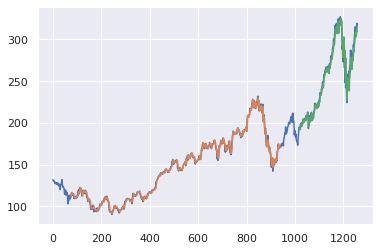

In [38]:
# ## Plotting 
# shift train predictions for plotting
look_back=75
trainPredictPlot = np.empty_like(newdataframe)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(newdataframe)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(newdataframe)-1, :] = test_predict
# plot baseline and predictions
plt.plot(minmaxscaler.inverse_transform(newdataframe))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [47]:
len(testdata)

315

In [48]:
# Take the last 75 days data to predict


x_input=testdata[240:].reshape(1,-1)
x_input.shape

(1, 75)

In [49]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.9915984125643842,
 0.9697289538123788,
 0.9761462467280253,
 0.9679557544541082,
 1.0000000000000002,
 0.9901629654648318,
 0.9905007177235499,
 0.9653803934813816,
 0.9848855864223593,
 0.9708688676855528,
 0.9402600692392133,
 0.8774803681499621,
 0.8348391454867856,
 0.8541332432660644,
 0.7733682344000676,
 0.7726927298826314,
 0.8801401671873683,
 0.8400743054969182,
 0.8967322468969012,
 0.8552731571392387,
 0.8388499535590646,
 0.7423372456303303,
 0.8232711306256861,
 0.7814320695769654,
 0.6665963016127672,
 0.7921557037912694,
 0.6411804441442204,
 0.6861437135860848,
 0.6600101325677616,
 0.6520307354555435,
 0.5864223591995272,
 0.5658616904500551,
 0.660896732246897,
 0.6551549438486872,
 0.7097019336316812,
 0.664527569028118,
 0.6943764248923416,
 0.692181035210673,
 0.6356919699400492,
 0.6526640209406402,
 0.637802921557038,
 0.7267162036646122,
 0.7138816178333194,
 0.7419150553069325,
 0.7500211095161702,
 0.7722283205268936,
 0.8304905851557884,
 0.81942919868276

In [50]:
len(temp_input)

75

In [51]:
lst_output=[]
n_steps=75
i=0
while(i<30):
    
    if(len(temp_input)>75):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9499285]
76
1 day input [0.96972895 0.97614625 0.96795575 1.         0.99016297 0.99050072
 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037 0.83483915
 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431 0.89673225
 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207 0.6665963
 0.7921557  0.64118044 0.68614371 0.66001013 0.65203074 0.58642236
 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757 0.69437642
 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162  0.71388162
 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292  0.8289707
 0.8125475  0.78776492 0.75162543 0.78426074 0.77974331 0.81326522
 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883 0.85628641
 0.87486279 0.88782403 0.90095415 0.92793211 0.948535   0.93333615
 0.91746179 0.92544119 0.91771511 0.9483239  0.94064004 0.96635143
 0.9563033  0.96491598 0.94992852]
1 day output [[0.93636906]]
2 day input [0.97614625 0.96795575 1.         0.99016297 0.99050072 0.96538039
 0.98488559 0.97086887 0.9402

In [58]:
day_new=np.arange(1,76)
day_pred=np.arange(76,106)


In [57]:
len(day_new)

74

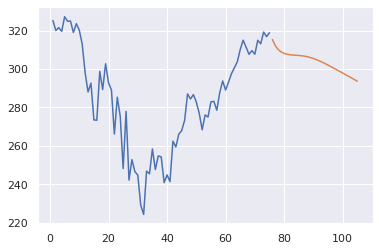

In [59]:
plt.plot(day_new,minmaxscaler.inverse_transform(newdataframe[1183:]))
plt.plot(day_pred,minmaxscaler.inverse_transform(lst_output))